#### DOMAIN:
- Entertainment
#### CONTEXT:
- Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and multimedia experts who need to detect faces from screen shots from the movie scene. The data labelling is already done.
####  DATA DESCRIPTION:
- The dataset comprises of face images.
####  PROJECT OBJECTIVE:
- To create an image dataset to be used by AI team build an image classifier data. Profile images of people are given.


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Import necessary libraries
import re
import numpy as np
from PIL import Image
import cv2
import random
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import preprocess_input
#from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D
from tensorflow.keras.models import Model

####  Read/import images from folder ‘training_images’.

In [22]:
#Import libraries
from tqdm.notebook import trange, tqdm
from IPython.display import Image, display, Markdown, clear_output
from zipfile import ZipFile

In [23]:
#"G:\My Drive\AIML_Program\ComputerVision\Project\training_images.zip"
project_path = '/content/drive/MyDrive/AIML_Program/ComputerVision/Project/'
image_files = 'training_images.zip'

In [24]:
#Unzip the files:
images_zip_path = os.path.join(project_path, image_files)

with ZipFile(images_zip_path, 'r') as z:
  z.extractall()

In [25]:
#Fetch unzip path location
zip_dir_path = z.filelist[0].filename.split("/")[0]
zip_dir_path

'training_images'

In [26]:
# Get first 10 image names:
image_file_names = [os.path.join(zip_dir_path,i) for i in os.listdir(zip_dir_path)]
image_file_names[:10]

['training_images/real_00010.jpg',
 'training_images/real_00779.jpg',
 'training_images/real_00371.jpg',
 'training_images/real_00648.jpg',
 'training_images/real_00791.jpg',
 'training_images/real_00263.jpg',
 'training_images/real_00938.jpg',
 'training_images/real_00219.jpg',
 'training_images/real_00369.jpg',
 'training_images/real_00500.jpg']

##### Read the images/image names

In [27]:
image_list = []
for images in tqdm(image_file_names):
  test_image = cv2.imread(images)
  image_list.append(test_image)
image_list = np.array(image_list)
display(Markdown(f"#### {image_list.shape}"))

  0%|          | 0/1091 [00:00<?, ?it/s]

#### (1091, 600, 600, 3)

##### There are total 1091 colored images each with 600X600 dimensions and 3 channels(RGB).

##### Lets visualize first 5 images:

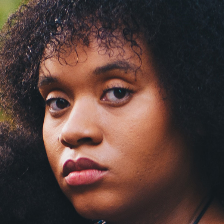

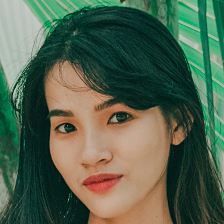

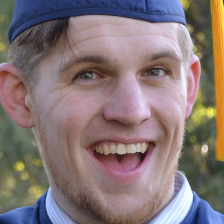

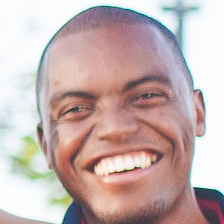

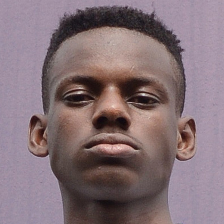

In [28]:
from google.colab.patches import cv2_imshow

for i in image_list[:5,]:
  cv2_imshow(cv2.resize(i,(224,224)))

#### Q2: Write a loop which will iterate through all the images in the ‘training_images’ folder and detect the faces present on all the images.
#### Q3: From the same loop above, extract metadata of the faces and write into a DataFrame

##### Download HAAR cascade image classifier which can be used with OpenCV:
- The haarcascade_frontalface_alt.xml file specifically is a pre-trained Haar Cascade classifier file for detecting frontal faces in images.

In [29]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

--2024-06-04 10:01:48--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml.2’

haarcascade_frontal 100%[===================>] 908.33K  4.47MB/s    in 0.2s    

2024-06-04 10:01:49 (4.47 MB/s) - ‘haarcascade_frontalface_default.xml.2’ saved [930127/930127]



In [30]:
haar_img_box_df = pd.DataFrame(columns=['x','y','w','h','Total_Faces','Image_Name'])
haar_img_box_df

,x,y,w,h,Total_Faces,Image_Name


#### Use HAAR Model to detect faces in all the image files of the folder.

### Bounding Box parameters are `x`:17, `y`:84, `width`:448, `height`:448

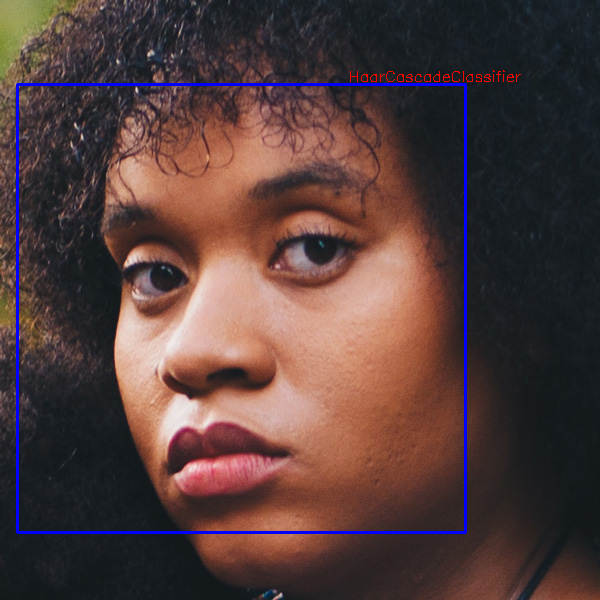

In [31]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

test_image = cv2.imread(image_file_names[0])
grey = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
# Detect faces
faces = face_cascade.detectMultiScale(grey,1.1,4)
# Draw rectangle around the faces
for (x, y, w, h) in faces:
  cv2.rectangle(test_image, (x, y), (x+w, y+h), (255, 0, 0), 2)
  cv2.putText(test_image, "HaarCascadeClassifier", (int((x+w)*0.75),y-3),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255))

# Display the output
display(Markdown(f"### Bounding Box parameters are `x`:{x}, `y`:{y}, `width`:{w}, `height`:{h}"))
cv2_imshow(test_image)

##### Detect faces for all the images

In [33]:
%%time
haar_undetected_images = []
haar_detected_images = []
temp_list = []

for images, fnames in tqdm(zip(image_list, image_file_names)):
  gray = cv2.cvtColor(images,cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray,1.1,4)
  if len(faces) == 0:
    haar_undetected_images.append(fnames)
    temp_dict = {'x':0,
                 'y':0,
                 'w':-1,
                 'h':-1,
                 'Total_Faces':0,
                 'Image_Name':fnames}
  else:
    haar_detected_images.append(fnames)
    for (x,y,w,h) in faces:
      temp_dict = {'x':x,
                  'y':y,
                  'w':w,
                  'h':h,
                  'Total_Faces':len(faces),
                  'Image_Name':fnames}
  temp_list.append(temp_dict)
haar_img_box_df = pd.DataFrame(temp_list)
#haar_img_box_df = haar_img_box_df.append(temp_dict,ignore_index=True)
display(Markdown(f"#### Detected faces for {len(haar_detected_images)} images"))
display(Markdown(f"#### Failed to detect faces for {len(haar_undetected_images)} images"))

0it [00:00, ?it/s]

#### Detected faces for 930 images

#### Failed to detect faces for 161 images

CPU times: user 6min 20s, sys: 4.76 s, total: 6min 25s
Wall time: 4min 4s


In [72]:
#dataframe containing all the images meta data.
haar_img_box_df


,x,y,w,h,Total_Faces,Image_Name
0,17,84,448,448,1,training_images/real_00010.jpg
1,73,191,370,370,1,training_images/real_00779.jpg
2,114,32,439,439,1,training_images/real_00371.jpg
3,66,92,459,459,1,training_images/real_00648.jpg
4,79,72,437,437,1,training_images/real_00791.jpg
...,...,...,...,...,...,...
1086,0,0,-1,-1,0,training_images/real_00316.jpg
1087,6,300,54,54,1,training_images/real_00413.jpg
1088,33,115,385,385,1,training_images/real_00439.jpg
1089,167,149,398,398,1,training_images/real_00557.jpg


In [47]:
haar_img_box_df[haar_img_box_df['Total_Faces'] > 1]

,x,y,w,h,Total_Faces,Image_Name
7,535,437,60,60,2,training_images/real_00219.jpg
48,121,358,130,130,2,training_images/real_00026.jpg
55,107,173,384,384,2,training_images/real_00262.jpg
87,19,298,88,88,2,training_images/real_00606.jpg
90,70,103,466,466,2,training_images/real_00304.jpg
...,...,...,...,...,...,...
1001,20,387,56,56,2,training_images/real_00415.jpg
1012,231,289,128,128,2,training_images/real_00596.jpg
1036,287,419,62,62,2,training_images/real_00706.jpg
1063,84,128,73,73,2,training_images/real_00423.jpg


In [51]:
#Get the images whose faces are more than 2 detected.
df_new = haar_img_box_df[haar_img_box_df['Total_Faces'] > 2]
df_new

,x,y,w,h,Total_Faces,Image_Name
125,81,249,139,139,3,training_images/real_00730.jpg
139,13,562,28,28,3,training_images/real_00049.jpg
261,100,217,332,332,3,training_images/real_00837.jpg
358,501,405,52,52,3,training_images/real_00905.jpg
858,134,173,356,356,3,training_images/real_00004.jpg
915,22,504,75,75,3,training_images/real_00980.jpg


#### There are 75 images which has more than one faces.

#### Function to get bounding boxes

In [57]:
def create_bb(df,fname,title=""):

  image = cv2.imread(fname)
  temp_df = df[df['Image_Name'] == fname]
  rect_img = []
  for rows in temp_df.index:
    x = df['x'][rows]
    y = df['y'][rows]
    w = df['w'][rows]
    h = df['h'][rows]
    cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),2)
    cv2.putText(image, title, (int((x+w)*0.75),y-3),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255))
  cv2_imshow(image)

  return

#### Function to read images, resize and display

In [58]:
def show_face(image_list,scale=1.0):

  for images in image_list:
    img = cv2.imread(images)
    img_w  = int(img.shape[1]*scale)
    img_h = int(img.shape[0]*scale)
    img = cv2.resize(img,(img_w,img_h))
    display(Markdown(f"#### {images}"))
    cv2_imshow(img)

  return

Display the images whose faces are correctly/incorrectly detected using HAAR model.

### (1) Correctly detected 1 face

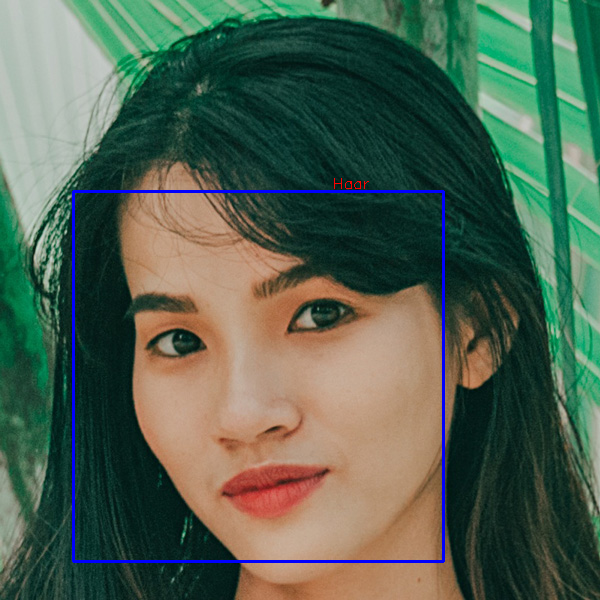

### (2) Incorrectly detected multiple faces

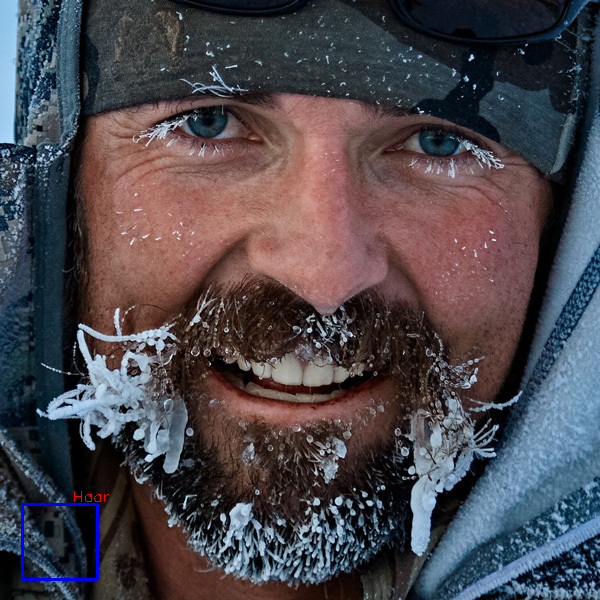

In [66]:
display(Markdown("### (1) Correctly detected 1 face"))
create_bb(haar_img_box_df,"training_images/real_00779.jpg",title="Haar")
display(Markdown("### (2) Incorrectly detected multiple faces"))
create_bb(haar_img_box_df,"training_images/real_00980.jpg",title="Haar")

#### Show incorrectly detected faces from HAAR model

#### training_images/real_00607.jpg

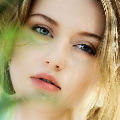

#### training_images/real_00536.jpg

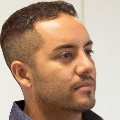

#### training_images/real_00788.jpg

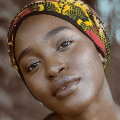

#### training_images/real_01054.jpg

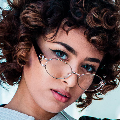

#### training_images/real_00147.jpg

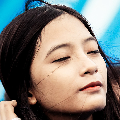

#### training_images/real_00628.jpg

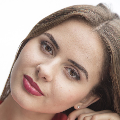

#### training_images/real_00099.jpg

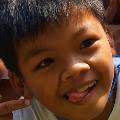

#### training_images/real_00056.jpg

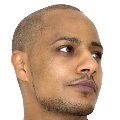

#### training_images/real_00070.jpg

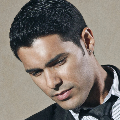

#### training_images/real_00316.jpg

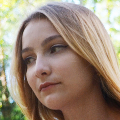

In [69]:
show_face(haar_undetected_images[-10:],scale=0.2)

####  Q4: Save the output Dataframe in .csv format.

In [73]:
haar_images_detected_df = haar_img_box_df[haar_img_box_df['Total_Faces'] > 0]
haar_images_detected_df

,x,y,w,h,Total_Faces,Image_Name
0,17,84,448,448,1,training_images/real_00010.jpg
1,73,191,370,370,1,training_images/real_00779.jpg
2,114,32,439,439,1,training_images/real_00371.jpg
3,66,92,459,459,1,training_images/real_00648.jpg
4,79,72,437,437,1,training_images/real_00791.jpg
...,...,...,...,...,...,...
1085,121,148,396,396,1,training_images/real_00619.jpg
1087,6,300,54,54,1,training_images/real_00413.jpg
1088,33,115,385,385,1,training_images/real_00439.jpg
1089,167,149,398,398,1,training_images/real_00557.jpg


In [74]:
# Specify the file path where the CSV will be saved
file_name = 'images_detected.csv'

# Save the DataFrame to a CSV file
haar_images_detected_df.to_csv(file_name, index=False)

########## END OF PART B #######################